# Part 1: Data Exploration

1. Read in the dataset, and display some summaries of the data.

2. Fix any concerns you have about the data.

3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

In [5]:
#import packages
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from tpot import TPOTRegressor
#read in the data
data = pd.read_csv("/Users/stolieerickson/Documents/MSBA/Fall/GSB544-Computing/Labs/insurance_costs_1.csv")
data.head()
#summary statistics
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(data.describe())
#variable data types
print(data.dtypes)
#create necessary dummy variables
data_clean = pd.get_dummies(data, columns=["sex", "smoker", "region"], drop_first=True)
#missing values
print(data_clean.isnull().sum())

              age         bmi       charges
count  431.000000  431.000000    431.000000
mean    37.960557   30.768898  12297.098118
std     16.363909    6.111362  11876.527128
min     18.000000   15.960000   1131.506600
25%     22.000000   26.357500   2710.444575
50%     34.000000   30.590000   9866.304850
75%     55.000000   35.272500  14510.872600
max     64.000000   49.060000  55135.402090
age          int64
sex         object
bmi        float64
smoker      object
region      object
charges    float64
dtype: object
age                 0
bmi                 0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64
              age         bmi       charges
count  431.000000  431.000000    431.000000
mean    37.960557   30.768898  12297.098118
std     16.363909    6.111362  11876.527128
min     18.000000   15.960000   1131.506600
25%     22.000000   26.357500   2710.444575
50%     34.000000   30.

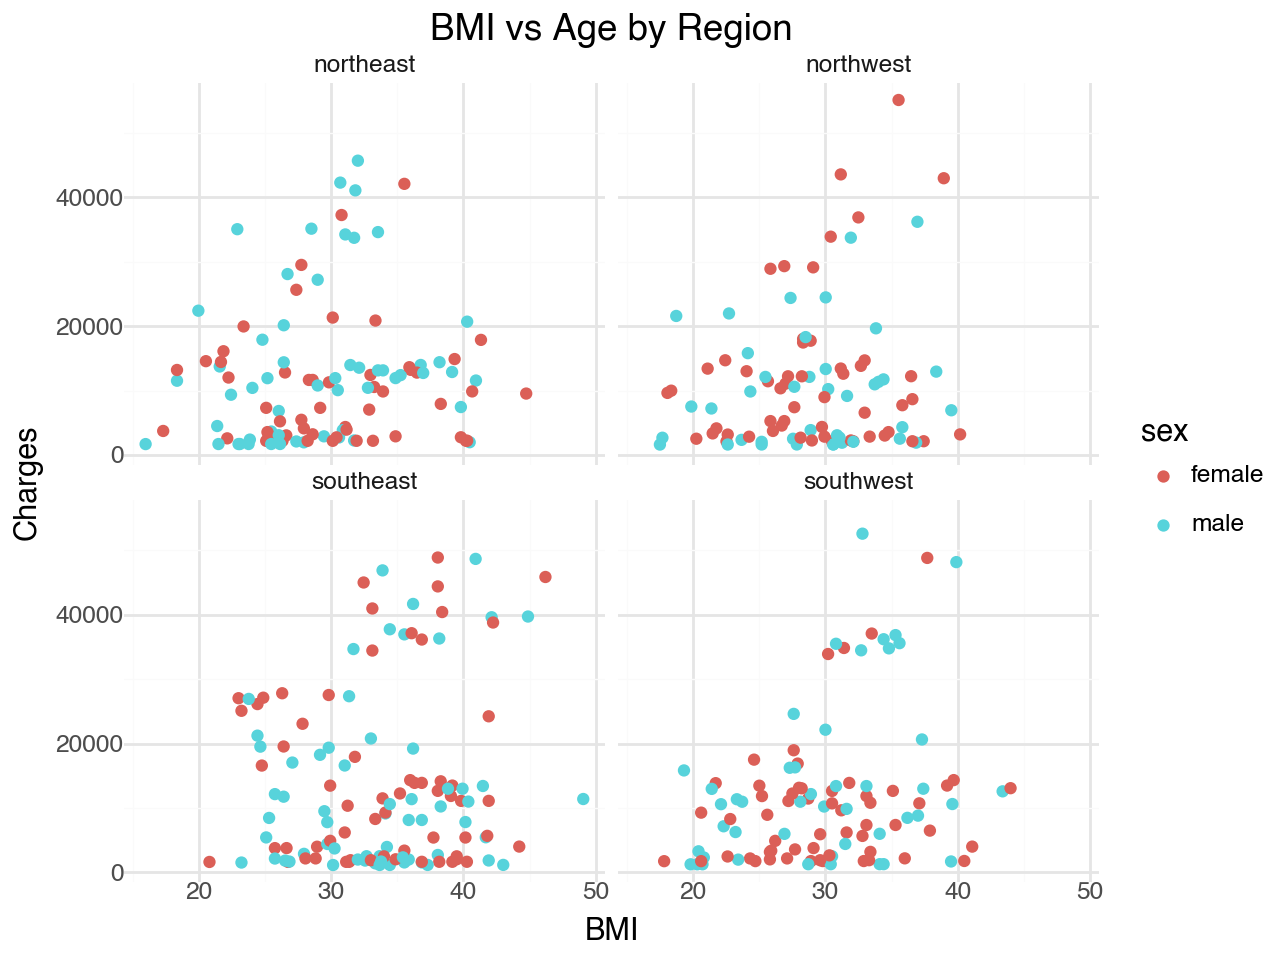

In [6]:
#bmi vs charges by region and sex
(ggplot(data, aes(x="bmi", y="charges", color = "sex")) 
    + geom_point()
    + facet_wrap("region")
    + labs(title="BMI vs Age by Region", 
           x="BMI", y="Charges")
    + theme_minimal())

The plot depicting BMI vs. Charges by Region and Sex illustrates a notable pattern: there appears to be a similar relationship between BMI and medical charges across all regions. As BMI increases, we observe a fanning effect, indicating that the variance in charges also increases. This suggests that higher BMI is associated with higher medical costs, and the range of charges becomes broader for individuals with higher BMI values. This insight highlights the potential impact of body mass on healthcare expenses, which may vary not only by individual characteristics but also by geographic location.

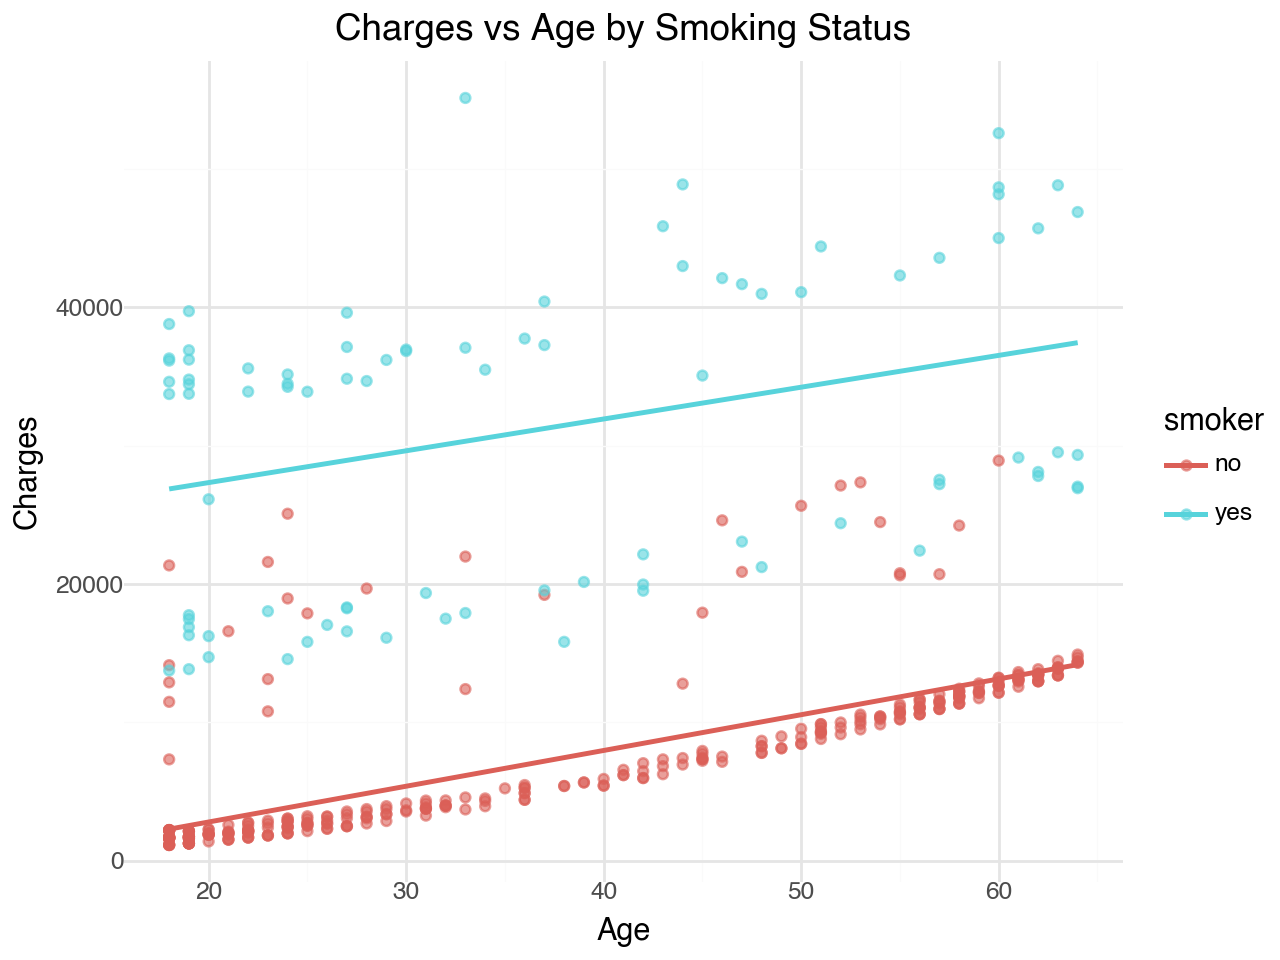

In [7]:
#age vs charges by smoking status
(ggplot(data, aes(x="age", y="charges", color="smoker"))
    + geom_point(alpha=0.6)
    + geom_smooth(method="lm", se=False)
    + labs(title="Charges vs Age by Smoking Status", 
           x="Age", y="Charges")
    + theme_minimal())

The plot illustrating Charges vs. Age by Smoking Status reveals that smokers incur significantly higher medical charges than non-smokers, as indicated by the noticeable gap between the two lines. Most non-smokers have smaller charges, but there are a few outlier observations among non-smokers with higher charges, which are pulling up the regression line.

Additionally, as age increases, charges appear to rise for both smokers and non-smokers. This trend suggests that older individuals, regardless of smoking status, tend to face higher medical expenses, potentially reflecting the increased healthcare needs associated with aging.

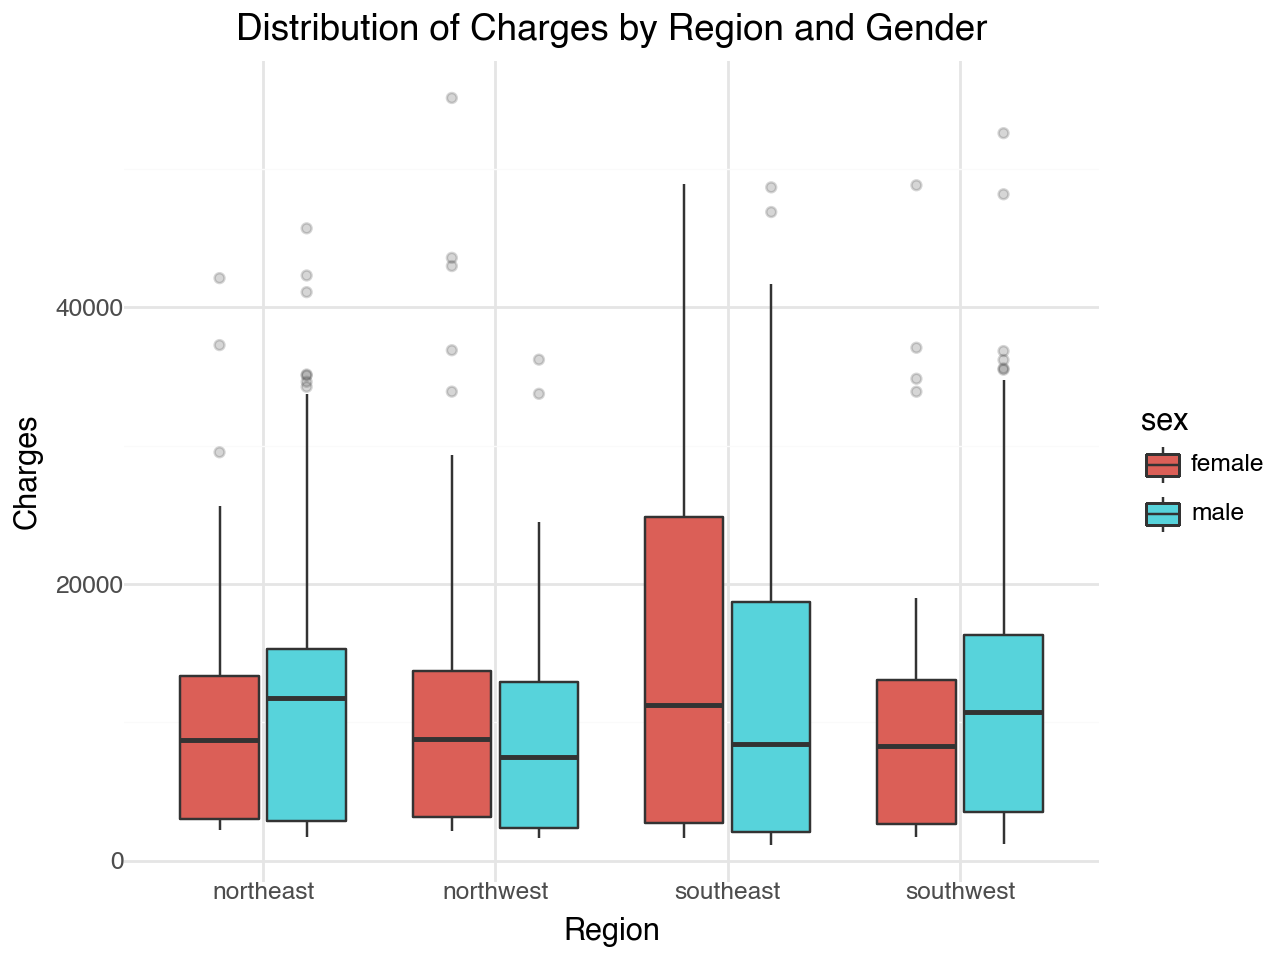

In [8]:
(ggplot(data, aes(x="region", y="charges", fill="sex"))
    + geom_boxplot(outlier_alpha=0.2)
    + labs(title="Distribution of Charges by Region and Gender", 
           x="Region", y="Charges")
    + theme_minimal())

The boxplot illustrating Charges by Region and Gender shows that the Southeast region has the highest spread of medical charges overall, as well as significant variation between sexes. Outliers with extremely high charges are present across all regions, indicating considerable variability in healthcare costs.

Furthermore, the median charges for females are higher than those for males in the Northeast and Southwest regions. Conversely, in the Northwest and Southeast regions, the median charges for males exceed those of females. This indicates potential regional disparities in healthcare costs based on gender, suggesting that both regional location and sex play a significant role in determining medical expenses.

# Part 2: Simple Linear Models

1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

In [9]:
def summarize_model(data, xvariables, yvariable, polynomialdegree = 1, return_model = True):

    #model1 variables
    X1 = data[xvariables]
    y = data[yvariable]

    #split with seed
    X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=1)

    #fit model1
    model1 = Pipeline([
        ('poly_features', PolynomialFeatures(degree=polynomialdegree, include_bias=False)),
        ('linear_regression', LinearRegression())
    ])
    model1.fit(X1_train, y_train)

    #model1 summary
    train_pred1 = model1.predict(X1_train)
    test_pred1 = model1.predict(X1_test)
    mse_train1 = mean_squared_error(y_train, train_pred1)
    mse_test1 = mean_squared_error(y_test, test_pred1)
    r2_train1 = r2_score(y_train, train_pred1)
    r2_test1 = r2_score(y_test, test_pred1)
    
    #extract intercept and coefficients
    intercept = model1.named_steps['linear_regression'].intercept_
    coefficients = model1.named_steps['linear_regression'].coef_
    feature_names = model1.named_steps['poly_features'].get_feature_names_out(xvariables)

    #print
    print(f"Model Summary (Predictors: {', '.join(xvariables)}):")
    print(f"Intercept: {intercept:.2f}")
    for i, (feature, coef) in enumerate(zip(feature_names, coefficients)):
        print(f"Coefficient for {feature}: {coef:.2f}")
    print(f"Training MSE: {mse_train1:.2f}, Training R^2: {r2_train1:.2f}")
    print(f"Test MSE: {mse_test1:.2f}, Test R^2: {r2_test1:.2f}\n")

    if return_model:
        return model1

In [10]:
#model1
summarize_model(data_clean, ["age"], "charges")

Model Summary (Predictors: age):
Intercept: 3769.22
Coefficient for age: 231.67
Training MSE: 136790047.54, Training R^2: 0.09
Test MSE: 87360446.32, Test R^2: 0.12

Model Summary (Predictors: age):
Intercept: 3769.22
Coefficient for age: 231.67
Training MSE: 136790047.54, Training R^2: 0.09
Test MSE: 87360446.32, Test R^2: 0.12



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linear_regression', LinearRegression())])

The regression model is: $\hat{\text{Charges}} = 3769.22 + 231.67Age$ The R squared on the test set is 0.12. This means that 12% of the variation in charges is explained by the model using only age as a predictor variable. Because we do not have another model (yet) to compare the MSE to, we cannot make judgements on whether this is a "good" fit or not. The interpretation of the intercept: 3769.22 is the expected or estimated medical charge for an individual with an age of 0, which does not make sense to interpret (we do not observe patients with an age of 0). The interpretation of age is: For each additional year of age, charges are expected to increase by $231.67 on average. 

2. Make a model that also incorporates the variable sex. Report your results.

In [11]:
#model2
summarize_model(data_clean, ["age", "sex_male"], "charges")

Model Summary (Predictors: age, sex_male):
Intercept: 3331.48
Coefficient for age: 231.51
Coefficient for sex_male: 936.42
Training MSE: 136571435.09, Training R^2: 0.10
Test MSE: 87817757.43, Test R^2: 0.11

Model Summary (Predictors: age, sex_male):
Intercept: 3331.48
Coefficient for age: 231.51
Coefficient for sex_male: 936.42
Training MSE: 136571435.09, Training R^2: 0.10
Test MSE: 87817757.43, Test R^2: 0.11



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linear_regression', LinearRegression())])

3. Now make a model that does not include sex, but does include smoker. Report your results.

In [12]:
#model3
summarize_model(data_clean, ["age", "smoker_yes"], "charges")

Model Summary (Predictors: age, smoker_yes):
Intercept: -1948.08
Coefficient for age: 247.45
Coefficient for smoker_yes: 25170.80
Training MSE: 34166961.28, Training R^2: 0.77
Test MSE: 33276382.05, Test R^2: 0.66

Model Summary (Predictors: age, smoker_yes):
Intercept: -1948.08
Coefficient for age: 247.45
Coefficient for smoker_yes: 25170.80
Training MSE: 34166961.28, Training R^2: 0.77
Test MSE: 33276382.05, Test R^2: 0.66



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linear_regression', LinearRegression())])

4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

I think that Model3 (the model that includes Age and Smoker as predictor variables) better fits the data. The R squared for Model2 is 0.11, while the R squared for Model3 is 0.66. Additionally, the test MSE for Model3 is smaller than the test MSE for Model2. Finally, we saw from the preliminary plots that whether or not the patient was a smoker appeared to have an extremely strong influence on the charges incurred, compared to the sex of the patient.

# Part 3: Multiple Linear Models

1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [13]:
#model4
summarize_model(data_clean, ["age", "bmi"], "charges")

Model Summary (Predictors: age, bmi):
Intercept: -4118.93
Coefficient for age: 213.52
Coefficient for bmi: 274.78
Training MSE: 133997790.55, Training R^2: 0.11
Test MSE: 83569014.93, Test R^2: 0.15

Model Summary (Predictors: age, bmi):
Intercept: -4118.93
Coefficient for age: 213.52
Coefficient for bmi: 274.78
Training MSE: 133997790.55, Training R^2: 0.11
Test MSE: 83569014.93, Test R^2: 0.15



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linear_regression', LinearRegression())])

The test MSE in Part Two Q1 was 87360446.32, and the test MSE for this model is 83569014.93, meaning that Model4 is preferred over Model1 (because it has a smaller MSE). The R squared in Model1 was .11, and the R squared for Model4 is 0.15. However, we cannot compare these models on the basis of regular R squared becuase they have different number of predictor variables.

2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

In [14]:
#model5
summarize_model(data_clean, ["age"], "charges", polynomialdegree = 2)

Model Summary (Predictors: age):
Intercept: 3979.93
Coefficient for age: 218.86
Coefficient for age^2: 0.16
Training MSE: 136789294.88, Training R^2: 0.09
Test MSE: 87413315.31, Test R^2: 0.12

Model Summary (Predictors: age):
Intercept: 3979.93
Coefficient for age: 218.86
Coefficient for age^2: 0.16
Training MSE: 136789294.88, Training R^2: 0.09
Test MSE: 87413315.31, Test R^2: 0.12



Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('linear_regression', LinearRegression())])

The MSE for this model is 87413315.31 and the test MSE for the model in part two question 1 is 87360446.32. The test R squared for model1 was 0.12, and the test R squared for this model is also 0.12. However, we cannot compare these models on the basis of R squared because they have different number of predictor variables. Theoretically, adjusted R squared would penalize for having additional predictor variables, and Model5 has a larger MSE, making it worse than Model1.

3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

In [15]:
#model6
summarize_model(data_clean, ["age"], "charges", polynomialdegree = 4)

Model Summary (Predictors: age):
Intercept: 72752.56
Coefficient for age: -8187.23
Coefficient for age^2: 359.32
Coefficient for age^3: -6.38
Coefficient for age^4: 0.04
Training MSE: 135773899.30, Training R^2: 0.10
Test MSE: 85868140.40, Test R^2: 0.13

Model Summary (Predictors: age):
Intercept: 72752.56
Coefficient for age: -8187.23
Coefficient for age^2: 359.32
Coefficient for age^3: -6.38
Coefficient for age^4: 0.04
Training MSE: 135773899.30, Training R^2: 0.10
Test MSE: 85868140.40, Test R^2: 0.13



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('linear_regression', LinearRegression())])

The MSE for this model is 85,868,140.40 and the test MSE for the model in part two question 1 is 87,360,446.32. The test R squared for Model1 was 0.12, and the test R squared for this model is 0.13. However, we cannot compare these models on the basis of R squared because they have different number of predictor variables. Model6 has a smaller test MSE, so it is considered the preferred model.

4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

In [16]:
#model7
summarize_model(data_clean, ["age"], "charges", polynomialdegree = 12)

Model Summary (Predictors: age):
Intercept: 5774.34
Coefficient for age: 0.00
Coefficient for age^2: -0.00
Coefficient for age^3: 0.00
Coefficient for age^4: 0.00
Coefficient for age^5: 0.00
Coefficient for age^6: 0.00
Coefficient for age^7: -0.00
Coefficient for age^8: 0.00
Coefficient for age^9: -0.00
Coefficient for age^10: 0.00
Coefficient for age^11: -0.00
Coefficient for age^12: 0.00
Training MSE: 135081669.07, Training R^2: 0.11
Test MSE: 90975131.13, Test R^2: 0.08

Model Summary (Predictors: age):
Intercept: 5774.34
Coefficient for age: 0.00
Coefficient for age^2: -0.00
Coefficient for age^3: 0.00
Coefficient for age^4: 0.00
Coefficient for age^5: 0.00
Coefficient for age^6: 0.00
Coefficient for age^7: -0.00
Coefficient for age^8: 0.00
Coefficient for age^9: -0.00
Coefficient for age^10: 0.00
Coefficient for age^11: -0.00
Coefficient for age^12: 0.00
Training MSE: 135081669.07, Training R^2: 0.11
Test MSE: 90975131.13, Test R^2: 0.08



Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=12, include_bias=False)),
                ('linear_regression', LinearRegression())])

The MSE for this model is 90,975,131.13 and the test MSE for the model in part two question 1 is 87,360,446.32. The test R squared for Model1 was 0.12, and the test R squared for this model is 0.08. However, we cannot compare these models on the basis of R squared because they have different number of predictor variables. This Model has a higher MSE, so Model1 would be preferred to this 12 degree polynomial model.

5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

Accoding to the MSE and R-squared, the best model of the models created in Part 3 of this lab is the model with age and bmi as predictor variables. I do not agree that this is indeed the "best" model because other variables and interactions may be present that could improve predictability. These interactions and models with several combinations of predictor variables should be explored.

6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

Model Summary (Predictors: age):
Intercept: 5774.34
Coefficient for age: 0.00
Coefficient for age^2: -0.00
Coefficient for age^3: 0.00
Coefficient for age^4: 0.00
Coefficient for age^5: 0.00
Coefficient for age^6: 0.00
Coefficient for age^7: -0.00
Coefficient for age^8: 0.00
Coefficient for age^9: -0.00
Coefficient for age^10: 0.00
Coefficient for age^11: -0.00
Coefficient for age^12: 0.00
Training MSE: 135081669.07, Training R^2: 0.11
Test MSE: 90975131.13, Test R^2: 0.08

Model Summary (Predictors: age):
Intercept: 5774.34
Coefficient for age: 0.00
Coefficient for age^2: -0.00
Coefficient for age^3: 0.00
Coefficient for age^4: 0.00
Coefficient for age^5: 0.00
Coefficient for age^6: 0.00
Coefficient for age^7: -0.00
Coefficient for age^8: 0.00
Coefficient for age^9: -0.00
Coefficient for age^10: 0.00
Coefficient for age^11: -0.00
Coefficient for age^12: 0.00
Training MSE: 135081669.07, Training R^2: 0.11
Test MSE: 90975131.13, Test R^2: 0.08



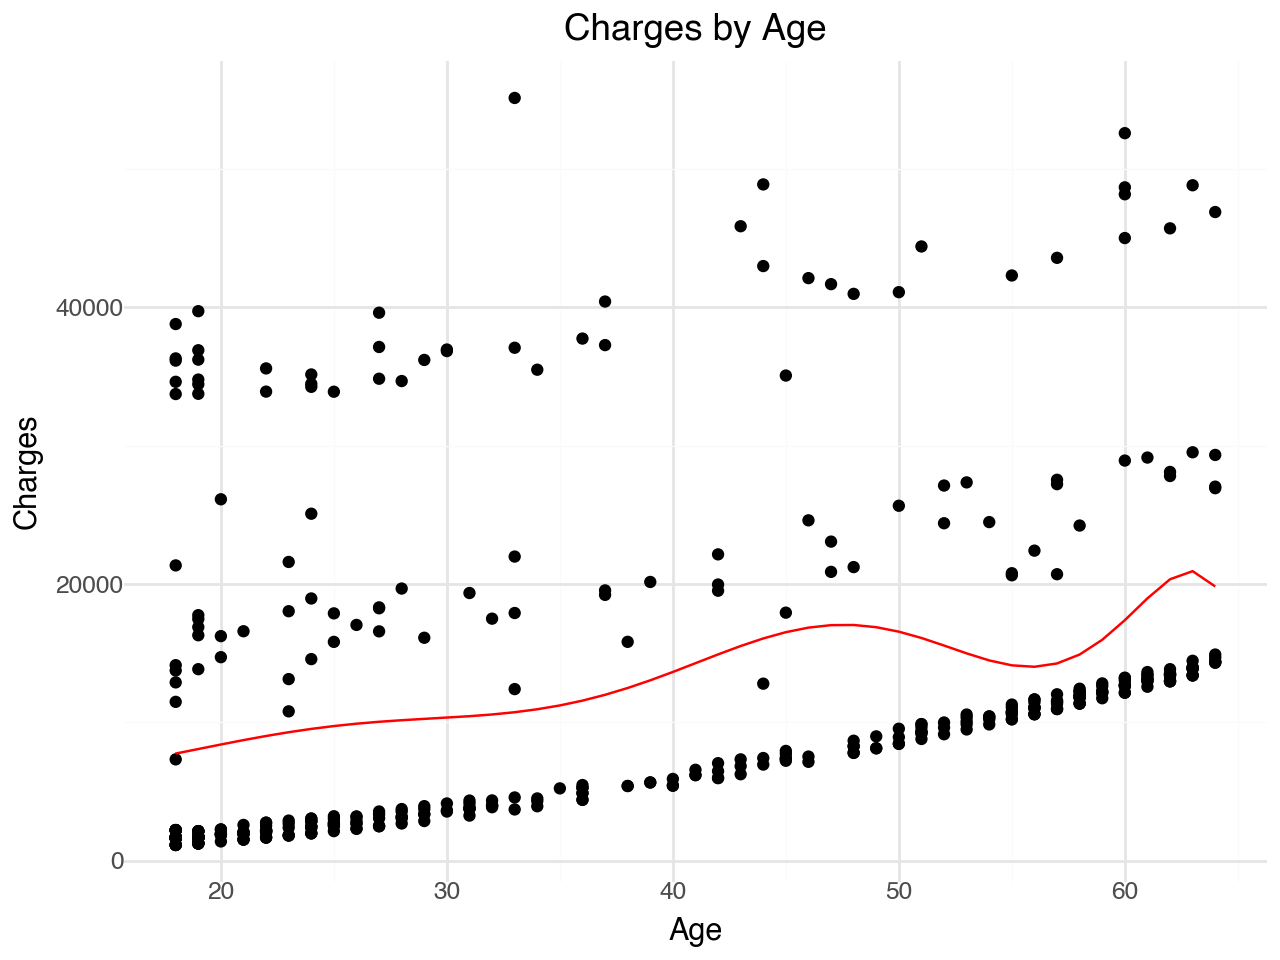

In [17]:
#store the model in an object
model7 = summarize_model(data_clean, ["age"], "charges", polynomialdegree=12)

#predictions
predictions = model7.predict(data_clean[["age"]])

#plotting data
plot_data = pd.DataFrame({
    "age": data_clean["age"],
    "charges": data_clean["charges"],
    "predicted": predictions
})

(ggplot(plot_data, aes(x="age", y="charges"))
    + geom_point()
    + geom_line(aes(y="predicted"), color="red")
    + labs(x="Age", y="Charges", title="Charges by Age")
    + theme_minimal()
)

# Part 4: New Data

For each model, fit the model on the original data.

Then, use the fitted model to predict on the new data.

Report the MSE for each model’s new predictions. Based on this, which is the best model to use?

Make a plot showing the residuals of your final chosen model.

In [18]:
#reading in the new data
data_2 = pd.read_csv("/Users/stolieerickson/Documents/MSBA/Fall/GSB544-Computing/Labs/insurance_costs_2.csv")
#create necessary dummy variables
data_clean2 = pd.get_dummies(data_2, columns=["sex", "smoker", "region"], drop_first=True)

a. Only age as a predictor.
b. age and bmi as a predictor.
c. age, bmi, and smoker as predictors (no interaction terms)
d. age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)
e. age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

In [23]:
#write the function
def model_mse(traindata, testdata, xvariables, yvariable):
    #modela
    Xa_train = traindata[xvariables]
    y_train = traindata[yvariable]
    Xa_test = testdata[xvariables]
    y_test = testdata[yvariable]

    #fit model
    modela = LinearRegression()
    modela.fit(Xa_train, y_train)

    #summarize
    train_preda = modela.predict(Xa_train)
    test_preda = modela.predict(Xa_test)
    mse_traina = mean_squared_error(y_train, train_preda)
    mse_testa = mean_squared_error(y_test, test_preda)

    #print
    return print(f"Model Summary (Predictors: {', '.join(xvariables)}): Test MSE: {mse_testa:.2f}")

#create new columns for interactions
data_clean["smokery_age"] = data_clean["smoker_yes"] * data_clean["age"]
data_clean["smokery_bmi"] = data_clean["smoker_yes"] * data_clean["bmi"]
#second dataset
data_clean2["smokery_age"] = data_clean2["smoker_yes"] * data_clean2["age"]
data_clean2["smokery_bmi"] = data_clean2["smoker_yes"] * data_clean2["bmi"]

In [24]:
model_mse(data_clean, data_clean2, ["age"], "charges")
model_mse(data_clean, data_clean2, ["age", "bmi"], "charges")
model_mse(data_clean, data_clean2, ["age", "bmi", "smoker_yes"], "charges")
model_mse(data_clean, data_clean2, ["age", "bmi", "smokery_age", "smokery_bmi"], "charges")
model_mse(data_clean, data_clean2, ["age", "bmi", "smoker_yes", "smokery_age", "smokery_bmi"], "charges")

Model Summary (Predictors: age): Test MSE: 136077136.50
Model Summary (Predictors: age, bmi): Test MSE: 132636406.11
Model Summary (Predictors: age, bmi, smoker_yes): Test MSE: 35377541.24
Model Summary (Predictors: age, bmi, smokery_age, smokery_bmi): Test MSE: 24795908.41
Model Summary (Predictors: age, bmi, smoker_yes, smokery_age, smokery_bmi): Test MSE: 21786256.87
Model Summary (Predictors: age): Test MSE: 136077136.50
Model Summary (Predictors: age, bmi): Test MSE: 132636406.11
Model Summary (Predictors: age, bmi, smoker_yes): Test MSE: 35377541.24
Model Summary (Predictors: age, bmi, smokery_age, smokery_bmi): Test MSE: 24795908.41
Model Summary (Predictors: age, bmi, smoker_yes, smokery_age, smokery_bmi): Test MSE: 21786256.87


In [21]:
#find minimum
#input results from above
mse_results = {
    "age": 136077136.50,
    "age, bmi": 132636406.11,
    "age, bmi, smoker_yes": 35377541.24,
    "age, bmi, smokery_age, smokery_bmi": 24795908.41,
    "age, bmi, smoker_yes, smokery_age, smokery_bmi": 21786256.87
}

#smallest MSE
min_mse_model = min(mse_results, key=mse_results.get)
min_mse_value = mse_results[min_mse_model]

#print
print(f"The model with the smallest test MSE is: '{min_mse_model}' with a Test MSE of {min_mse_value:.2f}")


The model with the smallest test MSE is: 'age, bmi, smoker_yes, smokery_age, smokery_bmi' with a Test MSE of 21786256.87
The model with the smallest test MSE is: 'age, bmi, smoker_yes, smokery_age, smokery_bmi' with a Test MSE of 21786256.87


Make a plot showing the residuals of your final chosen model.

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



Best Model Summary:
Predictors: age, bmi, smoker_yes, smokery_age, Degree: 2, Interaction Only: False
Best Test MSE: 21333664.98


Best Model Summary:
Predictors: age, bmi, smoker_yes, smokery_age, Degree: 2, Interaction Only: False
Best Test MSE: 21333664.98


<positron-console-cell-29>:80: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


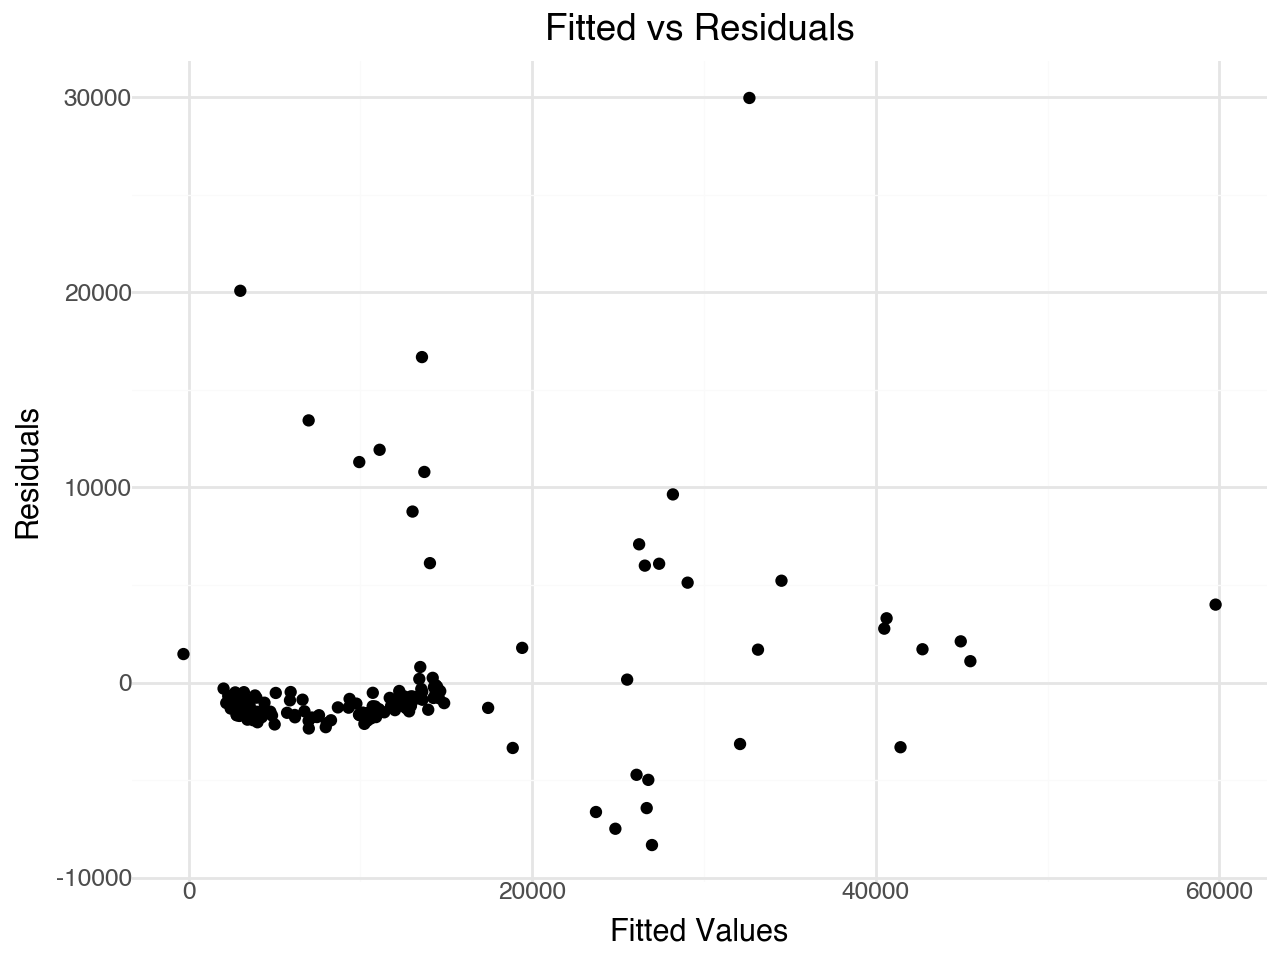

In [29]:
import itertools

def summarize_model(traindata, testdata, xvariables, yvariable, polynomialdegree=1, interaction_only=False, return_model=True):
    # Extract predictor and target variables
    X_train = traindata[xvariables]
    y_train = traindata[yvariable]
    X_test = testdata[xvariables]
    y_test = testdata[yvariable]

    # Define the model pipeline with PolynomialFeatures and LinearRegression
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=polynomialdegree, include_bias=False, interaction_only=interaction_only)),
        ('linear_regression', LinearRegression())
    ])
    model.fit(X_train, y_train)

    # Predict and evaluate
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    mse_train = mean_squared_error(y_train, train_pred)
    mse_test = mean_squared_error(y_test, test_pred)

    # Print model summary if desired
    if return_model:
        print(f"Model Summary (Predictors: {', '.join(xvariables)}, Degree: {polynomialdegree}, Interaction Only: {interaction_only}):")
        print(f"Test MSE: {mse_test:.2f}, Train MSE: {mse_train:.2f}")

    return model, mse_test, test_pred  # Return model, MSE, and test predictions

def find_best_model(traindata, testdata, predictors, yvariable):
    best_mse = float("inf")
    best_model = None
    best_degree = None
    best_vars = None
    best_test_pred = None
    best_interaction_only = None

    # Loop through combinations of predictor variables
    for r in range(1, len(predictors) + 1):
        for xvars in itertools.combinations(predictors, r):
            # Loop through polynomial degrees
            for degree in range(1, 13):
                # Test both with and without interaction-only terms
                for interaction_only in [True, False]:
                    model, mse_test, test_pred = summarize_model(
                        traindata, testdata, list(xvars), yvariable,
                        polynomialdegree=degree, interaction_only=interaction_only, return_model=False)
                
                    # Update if this model has a lower test MSE
                    if mse_test < best_mse:
                        best_mse = mse_test
                        best_model = model
                        best_degree = degree
                        best_vars = xvars
                        best_test_pred = test_pred
                        best_interaction_only = interaction_only

    # Print best model summary
    print(f"\nBest Model Summary:")
    print(f"Predictors: {', '.join(best_vars)}, Degree: {best_degree}, Interaction Only: {best_interaction_only}")
    print(f"Best Test MSE: {best_mse:.2f}")

    # Plot residuals
    residuals = testdata[yvariable] - best_test_pred
    plot_data = pd.DataFrame({
        "fitted": best_test_pred,
        "residuals": residuals
    })
    
    residual_plot = (ggplot(plot_data, aes(x="fitted", y="residuals"))
                     + geom_point()
                     + labs(x="Fitted Values", y="Residuals", title="Fitted vs Residuals")
                     + theme_minimal())
    print(residual_plot)

    return best_model

predictors = ["age", "bmi", "smoker_yes", "smokery_age", "smokery_bmi"]
best_model = find_best_model(data_clean, data_clean2, predictors, "charges")


# References and Appendix

- https://www.statsmodels.org/stable/api.html
- https://www.geeksforgeeks.org/linear-regression-python-implementation/

